Bienvenue dans la première partie de ce tutoriel consacré à un récent gros travail réalisé pour l'ONG d'enquête bretonne Splann!.

L'enjeu principal était de cartographier les maternités de la région à deux années clés (2000 et 2023), et de les superposer à des temps de trajet maximum en voiture.

Sans trop divulgâcher la suite, nous allons commencer en douceur **en géolocalisant les maternités en fonction de leur adresse**. Cela sera rendu possible grâce aux modules pandas mais surtout [Geopy](https://geopy.readthedocs.io/en/stable/), qui intègre des géocodeurs. Ils permettent de **transformer des adresses en doublets longitude/latitude** ou de passer des coordonnées géographiques à des adresses intelligibles.

Nous allons donc commencer par importer les modules en question :

In [1]:
import pandas as pd
from geopy.geocoders import Nominatim

Nous pouvons créer une première variable. Celle-ci sera une DataFrame classique, créée à partir d'un fichier [hébergé sur le portail officiel des Données statistiques publiques en santé et social](https://data.drees.solidarites-sante.gouv.fr/explore/dataset/fichier_maternites_112021/information/). Pour aller plus vite, j'ai hébergé le fichier en local dans un sous-dossier *raw* voisin de ce calepin.

Ce fichier est un Excel à plusieurs onglets, nous devrons donc spécifier l'onglet qui nous préoccupe (Maternités_2000) et de sauter le bon nombre de lignes pour afficher une base de données digne de ce nom :

In [2]:
maternites_2000 = pd.read_excel("raw/Fichier_Maternites_122024.xlsx",
                                sheet_name="Maternités_2000",
                                skiprows=5)
maternites_2000

,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT
0,CH FLEYRIAT BOURG-EN-BRESSE,2,PUBLIC,010000024,010780054,01451,VIRIAT,1440,900 RTE DE PARIS,32,4,2092
1,CH BELLEY,1,PUBLIC,010000032,010780062,01034,BELLEY,1300,52 R GEORGES GIRERD,12,2,377
2,CH OYONNAX,1,PUBLIC,010000057,010780088,01283,OYONNAX,1108,188 R ANATOLE FRANCE,20,2,648
3,CLINIQUE JEAN DE PARIS,1,PRIVE NON LUCRATIF,010780229,010006450,01004,AMBERIEU EN BUGEY,1500,58 AV PAUL PAINLEVE,15,2,389
4,CENTRE HOSPITALIER DE SAINT QUENTIN,2,PUBLIC,020000162,020000063,02691,ST QUENTIN,2321,1 AV MICHEL DE L'HOSPITAL,39,3,1372
...,...,...,...,...,...,...,...,...,...,...,...,...
716,GROUPE HOSPITALIER SUD REUNION,1,PUBLIC,970400081,970403614,97414,ST LOUIS,97450,AV RAYMOND VERGES,26,3,1155
717,CLINIQUE ST VINCENT,1,PRIVE LUCRATIF,970404844,970404836,97411,ST DENIS,97400,8 R DE PARIS,26,4,1041
718,CLINIQUE JEANNE D'ARC,2,PRIVE LUCRATIF,970462024,970400255,97407,LE PORT,97821,R ALSACE LORRAINE LYON,33,3,1679
719,CLINIQUE DURIEUX,1,PRIVE LUCRATIF,970462073,970400271,97422,LE TAMPON,97430,100 R DE FRANCE,15,4,927


721 maternités répertoriées en 2000, dont il nous faut **juste retenir les départements de Bretagne et la Loire-Atlantique**. Nous allons stocker leurs codes départementaux dans une liste :

In [3]:
dep_bzh = ["22",
           "29",
           "35",
           "44",
           "56"]

Nous allons filtrer la première DataFrame et l'assigner à une nouvelle variable. La colonne idéale pour cela est le code communal (*COM*), dont on ne retient que les deux premiers caractères afin de coller aux valeurs de la liste dep_bzh :

In [4]:
bzh_2000 = maternites_2000[maternites_2000["COM"].str.slice(0,2).isin(dep_bzh)].reset_index(drop=True)
bzh_2000.tail()

,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT
41,CLINIQUE DES AUGUSTINES-\nMALESTROIT,1,PRIVE NON LUCRATIF,560000184,560006017,56124,MALESTROIT,56140,4 FG SAINT MICHEL,9,3,449
42,CENTRE HOSPITALIER DE PLOERMEL,1,PUBLIC,560000192,560000044,56165,PLOERMEL,56800,FG GRIMAUD,20,2,501
43,CENTRE HOSPITALIER,1,PUBLIC,560000275,560005746,56083,HENNEBONT,56700,R DU DOCTEUR LAENNEC,15,2,325
44,CLINIQUE DU TER,1,PRIVE LUCRATIF,560002511,560000689,56162,PLOEMEUR,56270,LD KERBERNES,21,4,794
45,POLYCLINIQUE DU PARC,1,PRIVE LUCRATIF,560005290,560000903,56260,VANNES,56005,59 R MONSEIGNEUR TREHIOU,15,2,359


A présent, un gros morceau. Afin de géocoder les adresses, il faudra les rendres les plus intelligibles possibles. Mais, rien que dans les cinq dernières lignes de notre nouvelle base, **nous remarquons des libellés incomplets** (R au lieu de RUE, FG plutôt que FAUBOURG, LD à la place de LIEU-DIT). 

Ces simples notations risquent de poser problème, et une solution assez simple consister à coder **un dictionnaire entre les libellés raccourcis et leur dénomination complète**. Nous allons utiliser en clés [des expression régulières]("https://docs.python.org/fr/3.13/howto/regex.html") en isolant à chaque fois :
* **le raccourci isolé entre deux espaces** (nous ne voulons pas remplacer tous les R d'une chaîne de caractères par RUE, mais seulement ceux qui sont isolés)
* **le raccourci en tête d'adresse suivi d'un espace**. Typiquement les adresses pour lesquelles aucun numéro n'est spécifié

Ce qui donne :

In [5]:
corres_adresse = {" R ":" RUE ",
                  "^R ":"RUE ",
                  " CHE ":" CHEMIN ",
                  "^CHE ":"CHEMIN ",
                  " PL ":" PLACE ",
                  "^PL ":"PLACE ",
                  " RTE ":" ROUTE ",
                  "^RTE ":"ROUTE",
                  " BD ":" BOULEVARD ",
                  "^BD":"BOULEVARD ",
                  " AV ":" AVENUE ",
                  "^AV ":"AVENUE ",
                  " FG ":" FAUBOURG ",
                  "^FG ":"FAUBOURG ",
                  " ALL ":" ALLÉE ",
                  "^ALL ":"ALLÉE ",
                  " LD ":" LIEU-DIT ",
                  "^LD ":"LIEU-DIT "}

Ensuite nous pouvons, à l'aide d'une boucle for, récupérer chaque duo clé/valeur du dictionnaire, afin de mettre à jour le champ adresse de la base de données par les libellés complets. Cela va se passer avec la [fonction de pandas replace](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html), à laquelle il faut spécifier le paramètre regex car nous utilisons des expression régulières :

In [6]:
for k,v in corres_adresse.items():
    bzh_2000["ADRESSE"] = bzh_2000["ADRESSE"].str.replace(k,v,regex=True)

Affichons les cinq dernières lignes après cette boucle :

In [7]:
bzh_2000["ADRESSE"].tail()

41       4 FAUBOURG SAINT MICHEL
42              FAUBOURG GRIMAUD
43        RUE DU DOCTEUR LAENNEC
44            LIEU-DIT KERBERNES
45    59 RUE MONSEIGNEUR TREHIOU
Name: ADRESSE, dtype: object

Deuxième gros morceau : des éventuels allers/retours avec ce qui dépasse. Par exemple, prenons les cinq premières lignes de la BDD :

In [8]:
bzh_2000.head()

,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT
0,CENTRE HOSPITALIER DE ST-BRIEUC,3,PUBLIC,220000012,220000020,22278,ST BRIEUC,22023,10 RUE MARCEL PROUST,35,6,2091
1,CLINIQUE SAINT FRANCOIS SA,2,PRIVE LUCRATIF,220000038,220000673,22278,ST BRIEUC,22015,8 RUE CHARLES PRADAL,37,3,1060
2,CENTRE HOSPITALIER RENE PLEVEN,1,PUBLIC,220000095,220000046,22050,DINAN,22101,56 RUE CHATEAUBRIAND,15,3,953
3,CENTRE HOSPITALIER GUINGAMP,1,PUBLIC,220000343,220000079,22070,GUINGAMP,22205,17 RUE ARMOR PABU,17,2,684
4,CENTRE HOSPITALIER LANNION,1,PUBLIC,220000368,220000103,22113,LANNION,22303,,24,2,863


Il n'y a rien pour Lannion (et c'est mal). D'autres terminologies risquent de ne pas être retrouvées dans OpenStreetMap, par exemple les noms bretons. C'est notamment le cas pour une maternité renseignée PLACE ST GWENOL au lieu de PLACE SAINT GUENOLE.

Pour le coup, le travail (très artisanal) consiste à mettre à jour chaque cellule erronée grâce à la notation at\[index de ligne, nom de colonne\], ce qui donne dans notre cas :

In [9]:
bzh_2000.at[4,"ADRESSE"] = "RUE DE TROROZEC"
bzh_2000.at[14,"ADRESSE"] = "RUE DU DOCTEUR MENGUY"
bzh_2000.at[16,"ADRESSE"] = "20 AVENUE DU GENERAL LECLERC"
bzh_2000.at[17,"ADRESSE"] = "RUE ERNESTINE DE TREMAUDAN"
bzh_2000.at[19,"ADRESSE"] = "4 PLACE SAINT GUENOLE"
bzh_2000.at[39,"ADRESSE"] = "27 RUE DU DOCTEUR LETTRY"
bzh_2000.head()

,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT
0,CENTRE HOSPITALIER DE ST-BRIEUC,3,PUBLIC,220000012,220000020,22278,ST BRIEUC,22023,10 RUE MARCEL PROUST,35,6,2091
1,CLINIQUE SAINT FRANCOIS SA,2,PRIVE LUCRATIF,220000038,220000673,22278,ST BRIEUC,22015,8 RUE CHARLES PRADAL,37,3,1060
2,CENTRE HOSPITALIER RENE PLEVEN,1,PUBLIC,220000095,220000046,22050,DINAN,22101,56 RUE CHATEAUBRIAND,15,3,953
3,CENTRE HOSPITALIER GUINGAMP,1,PUBLIC,220000343,220000079,22070,GUINGAMP,22205,17 RUE ARMOR PABU,17,2,684
4,CENTRE HOSPITALIER LANNION,1,PUBLIC,220000368,220000103,22113,LANNION,22303,RUE DE TROROZEC,24,2,863


Il est temps de coder une première fonction qui, à l'aide d'une adresse complète (avec nom de ville inclus) va récupérer la latitude ou la longitude lorsque le géocodage se déroule bien. Nous allons [faire appel à Nominatim](https://nominatim.org/) pour ce faire, pour lequel un user-agent doit être obligatoirement spécifié.

Coquetterie supplémentaire : [des gestions d'exceptions](https://docs.python.org/3/tutorial/errors.html) qui permettront de signaler les adresses qui n'ont pu être géocodées, en se rabattant à ce moment-là sur le centre de la ville. Cette solution est surtout acceptable pour les plus petites villes et nous essaierons autant que possible de corriger ce qui peut l'être comme précédemment :

In [10]:
def extract_coord(adress:str,
                  coord="latitude") -> float:
    """
        Cette fonction renvoie la latitude ou la longitude correspondant à une adresse type RUE/VILLE.
    """
    geolocator = Nominatim(user_agent="operation_python",timeout=10)
    try:
        if coord=="latitude":
            return geolocator.geocode(adress).latitude
        elif coord=="longitude":
            return geolocator.geocode(adress).longitude
    except Exception as e:
        print(f"Le géocodage de l'adresse {adress} a planté, on se rabat sur le centre de la ville")
        if coord=="latitude":
            return geolocator.geocode(adress.split(",")[1]).latitude
        elif coord=="longitude":
            return geolocator.geocode(adress.split(",")[1]).longitude

Nous pouvons tester la bonne extraction de la latitude sur la première adresse :

In [11]:
# ATTENTION A NE PAS OUBLIER LE NOM DE LA VILLE
extract_coord(bzh_2000["ADRESSE"].iloc[0]+","+bzh_2000["NOMCOM"].iloc[0])

48.4942743

Et faire de même avec la longitude. Il suffit de modifier le paramètre coord (par défaut *latitude*) pour lui préférer *longitude* :

In [12]:
extract_coord(bzh_2000["ADRESSE"].iloc[2]+","+bzh_2000["NOMCOM"].iloc[2],
              coord="longitude")

-2.0463473

La fonction a marché, nous pouvons dès lors créer une Série pandas uniquement centrée sur les adresses complètes :

In [13]:
full_adress = bzh_2000["ADRESSE"]+","+bzh_2000["NOMCOM"]
full_adress.iloc[:5]

0    10 RUE MARCEL PROUST,ST BRIEUC
1    8 RUE CHARLES PRADAL,ST BRIEUC
2        56 RUE CHATEAUBRIAND,DINAN
3        17 RUE ARMOR PABU,GUINGAMP
4           RUE DE TROROZEC,LANNION
dtype: object

Nous allons mettre à jour la variable bzh_2000 en ajoutant une colonne *LATITUDE* qui se résumer à appliquer notre fonction sur la Série full_adress :

In [14]:
bzh_2000["LATITUDE"] = full_adress.apply(extract_coord)

Le géocodage de l'adresse RUE DU DOCTEUR LAENNEC,HENNEBONT a planté, on se rabat sur le centre de la ville
Le géocodage de l'adresse LIEU-DIT KERBERNES,PLOEMEUR a planté, on se rabat sur le centre de la ville


Plus qu'à faire de même avec les longitudes, sur le même modèle :

In [15]:
bzh_2000["LONGITUDE"] = full_adress.apply(extract_coord,coord="longitude")

Le géocodage de l'adresse RUE DU DOCTEUR LAENNEC,HENNEBONT a planté, on se rabat sur le centre de la ville
Le géocodage de l'adresse LIEU-DIT KERBERNES,PLOEMEUR a planté, on se rabat sur le centre de la ville


Nous sommes presque arrivées au bout de nos peines avec cette base de données :

In [16]:
bzh_2000

,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT,LATITUDE,LONGITUDE
0,CENTRE HOSPITALIER DE ST-BRIEUC,3,PUBLIC,220000012,220000020,22278,ST BRIEUC,22023,10 RUE MARCEL PROUST,35,6,2091,48.494274,-2.751554
1,CLINIQUE SAINT FRANCOIS SA,2,PRIVE LUCRATIF,220000038,220000673,22278,ST BRIEUC,22015,8 RUE CHARLES PRADAL,37,3,1060,48.500177,-2.752740
2,CENTRE HOSPITALIER RENE PLEVEN,1,PUBLIC,220000095,220000046,22050,DINAN,22101,56 RUE CHATEAUBRIAND,15,3,953,48.447343,-2.046347
3,CENTRE HOSPITALIER GUINGAMP,1,PUBLIC,220000343,220000079,22070,GUINGAMP,22205,17 RUE ARMOR PABU,17,2,684,48.568766,-3.144335
4,CENTRE HOSPITALIER LANNION,1,PUBLIC,220000368,220000103,22113,LANNION,22303,RUE DE TROROZEC,24,2,863,48.724798,-3.462531
5,C.H.I.C. PLEMET LOUDEAC,1,PUBLIC,220000483,220000129,22136,LOUDEAC,22600,RUE DE LA CHESNAIE,13,3,208,48.179749,-2.752676
6,CENTRE HOSPITALIER PAIMPOL,1,PUBLIC,220000541,220000152,22162,PAIMPOL,22501,CHEMIN DE MALABRY,10,3,277,48.771078,-3.032843
7,CHIC - QUIMPER -,2,PUBLIC,290000025,290020700,29232,QUIMPER,29107,14 AVENUE YVES THEPOT,28,6,1513,47.985935,-4.095777
8,CTRE HOSP. DES PAYS DE MORLAIX,2,PUBLIC,290000033,290021542,29151,MORLAIX,29600,15 RUE KERSAINT GILLY,24,3,823,48.569495,-3.830617
9,CHRU HOPITAL MORVAN,3,PUBLIC,290000058,290000017,29019,BREST,29609,5 AVENUE FOCH,64,4,1537,48.395174,-4.488361


Et maintenant ? Maintenant, nous allons ne retenir que les colonnes essentielles, telles que :

In [17]:
bzh_2000 = bzh_2000[["NOM_MAT","STATUT","FI_ET","NOMCOM","ADRESSE","ACCTOT","LATITUDE","LONGITUDE"]]

Nous pouvons passer à la suite, qui va tout simplement consister à nous pencher sur les maternités de notre grande zone, mais cette fois en 2023. Nous pouvons recycler l'exact appel de fichier Excel précédent, en modifiant juste le nom de l'onglet à considérer :

In [18]:
maternites_2023 = pd.read_excel("raw/Fichier_Maternites_122024.xlsx",
                                sheet_name="Maternités_2023",
                                skiprows=5)
maternites_2023

,ID_MAT,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT,SUIVI
0,M00003,CH DE FLEYRIAT,2b,PUBLIC,010000024,010780054,01451,VIRIAT,1440,900 RTE DE PARIS,28,5,1841,NaN
1,M00004,CH BUGEY SUD,1,PUBLIC,010000032,010780062,01034,BELLEY,1300,700 AV DE NARVIK,8,2,330,NaN
2,M00002,CH DU HAUT BUGEY - GEOVREISSET,1,PUBLIC,010005239,010008407,01283,OYONNAX,1108,1 RTE DE VEYZIAT,17,3,531,NaN
3,M00001,HOPITAL PRIVE D'AMBERIEU,1,PRIVE LUCRATIF,010780203,010010718,01004,AMBERIEU EN BUGEY,1506,EN PRAGNAT NORD,15,3,561,NaN
4,M00005,CH SAINT-QUENTIN,2b,PUBLIC,020000162,020000063,02691,SAINT QUENTIN,2321,1 R MICHEL DE L'HOSPITAL,28,5,1602,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,M00567,GHER (SAINT-BENOIT),2a,PUBLIC,970400073,970403606,9D410,SAINT BENOIT,97470,30 RTE RN 3,25,5,1381,NaN
453,M00565,CLINIQUE DURIEUX,1,PRIVE LUCRATIF,970462073,970400271,9D422,LE TAMPON,97430,100 R DE FRANCE,19,3,870,NaN
454,M00564,CLINIQUE LES ORCHIDEES,2a,PRIVE LUCRATIF,970462081,970400255,9D407,LE PORT,97420,30 AV LENINE,18,4,822,NaN
455,M00566,CLINIQUE STE-CLOTILDE,2a,PRIVE LUCRATIF,970462107,970400305,9D411,SAINT DENIS,97492,127 RTE DU BOIS DE NEFLES,30,5,1551,NaN


Nous filtrons ensuite sur les cinq départements d'intérêt :

In [19]:
bzh_2023 = maternites_2023[maternites_2023["COM"].str.slice(0,2).isin(dep_bzh)].reset_index(drop=True)
bzh_2023.tail()

,ID_MAT,NOM_MAT,TYPE,STATUT,FI_ET,FI_EJ,COM,NOMCOM,CPO,ADRESSE,LIT_OBS,SALTRAV,ACCTOT,SUIVI
24,M00253,CHBA SITE DE VANNES,3,PUBLIC,560000127,560023210,56260,VANNES,56017,20 BD GENERAL MAURICE GUILLAUDOT,38,5,1930,NaN
25,M00250,GHBS- HÔPITAL DU SCORFF,2b,PUBLIC,560000135,560005746,56121,LORIENT,56322,5 AV DE CHOISEUL,40,7,2335,NaN
26,M00252,CHCB- SITE KÉRIO,2a,PUBLIC,560000143,560014748,56151,NOYAL PONTIVY,56920,KÉRIO,15,5,753,NaN
27,M00248,CENTRE HOSPITALIER DE PLOERMEL,1,PUBLIC,560000192,560000044,56165,PLOERMEL,56800,7 R DU ROI ARTHUR,16,3,567,NaN
28,M00251,HÔPITAL PRIVÉ OCÉANE,2a,PRIVE LUCRATIF,560008799,560013989,56260,VANNES,56000,11 R DU DR JOSEPH AUDIC,20,4,854,NaN


29 maternités, contre 46 en 2000. La conclusion est sans appel : **des maternités ont disparu entre-temps**. Nous allons partir du principe que bon nombre de celles de 2023 existaient déjà en 2000, et **préparer une jointure entre les deux bases annuelles**.

Première étape : renommer sur chaque base les colonnes de nom de maternités et surtout de total d'accouchements. **Nous préférerons l'année pour cette dernière**, car ce sera très utile dans l'application finale pour basculer d'une année à l'autre en cliquant sur un bouton :

In [20]:
bzh_2000.rename(columns={"NOM_MAT":"NOM",
                         "ACCTOT":"2000"},inplace=True)
bzh_2023.rename(columns={"NOM_MAT":"NOM",
                         "ACCTOT":"2023"},inplace=True)

C:\Users\raphi\AppData\Local\Temp\ipykernel_4404\221457914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bzh_2000.rename(columns={"NOM_MAT":"NOM",


Ensuite, nous filtrons la base de 2023 uniquement sur les colonnes pertinentes :

In [22]:
bzh_2023 = bzh_2023[["NOM","STATUT","FI_ET","NOMCOM","ADRESSE","2023"]]
bzh_2023.tail()

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2023
24,CHBA SITE DE VANNES,PUBLIC,560000127,VANNES,20 BD GENERAL MAURICE GUILLAUDOT,1930
25,GHBS- HÔPITAL DU SCORFF,PUBLIC,560000135,LORIENT,5 AV DE CHOISEUL,2335
26,CHCB- SITE KÉRIO,PUBLIC,560000143,NOYAL PONTIVY,KÉRIO,753
27,CENTRE HOSPITALIER DE PLOERMEL,PUBLIC,560000192,PLOERMEL,7 R DU ROI ARTHUR,567
28,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 R DU DR JOSEPH AUDIC,854


Et maintenant, la jointure. La seule contrainte absolue est **d'avoir une colonne commune entre les deux bases**, si possible avec des identifiants stables. Dans cette idée, les **chiffres seront toujours mieux plus pertinents que des chaînes de caractères** qui peuvent avoir différents encodages et des règles de saisie différentes.

C'est pour cela que nous avons pris le soin de conserver la colonne *FI_ET*, contenant les identifiants des établissements. Si nous voulons ajouter les informations de 2023 à celles de 2020, une solution optimale consiste à filtrer la première base sur les seules colonnes *FI_ET* et *2023*, et à effectuer la jointure sur la colonne commune en prenant en référence toutes les lignes de 2020.

La [fonction merge de pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) est taillée pour ça :


In [23]:
mat = bzh_2000.merge(bzh_2023[["FI_ET","2023"]],on="FI_ET",how="left")
mat.head()

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,LATITUDE,LONGITUDE,2023
0,CENTRE HOSPITALIER DE ST-BRIEUC,PUBLIC,220000012,ST BRIEUC,10 RUE MARCEL PROUST,2091,48.494274,-2.751554,1951.0
1,CLINIQUE SAINT FRANCOIS SA,PRIVE LUCRATIF,220000038,ST BRIEUC,8 RUE CHARLES PRADAL,1060,48.500177,-2.752740,NaN
2,CENTRE HOSPITALIER RENE PLEVEN,PUBLIC,220000095,DINAN,56 RUE CHATEAUBRIAND,953,48.447343,-2.046347,NaN
3,CENTRE HOSPITALIER GUINGAMP,PUBLIC,220000343,GUINGAMP,17 RUE ARMOR PABU,684,48.568766,-3.144335,135.0
4,CENTRE HOSPITALIER LANNION,PUBLIC,220000368,LANNION,RUE DE TROROZEC,863,48.724798,-3.462531,527.0


Sans surprises, [des valeurs nulles](https://fr.wikipedia.org/wiki/NaN) (ou NaN) apparaissent dans la base jointurée. Elles correspondent aux maternités pour lesquelles on n'avait pas d'information en 2023, autrement dit celles qui ont disparu entre 2000 et 2023.

**La gestion des valeurs nulles peut constituer une vraie prise de tête** tant elle peut traduire une réelle altération des données, mais dans notre cas nous allons éviter de [ratiboiser la base afin de mettre la poussière sous le tapis](https://realpython.com/how-to-drop-null-values-in-pandas/).

La solution retenue va constituer plutôt à :
* remplacer les valeurs nulles par des zéro. Après tout, c'est le cas !
* reconvertir la colonne 2023 en nombres entiers plutôt qu'avec décimales

In [24]:
mat["2023"].fillna(0,inplace=True)
mat["2023"] = mat["2023"].astype(int)
mat.head()

C:\Users\raphi\AppData\Local\Temp\ipykernel_4404\2283604330.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mat["2023"].fillna(0,inplace=True)


,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,LATITUDE,LONGITUDE,2023
0,CENTRE HOSPITALIER DE ST-BRIEUC,PUBLIC,220000012,ST BRIEUC,10 RUE MARCEL PROUST,2091,48.494274,-2.751554,1951
1,CLINIQUE SAINT FRANCOIS SA,PRIVE LUCRATIF,220000038,ST BRIEUC,8 RUE CHARLES PRADAL,1060,48.500177,-2.752740,0
2,CENTRE HOSPITALIER RENE PLEVEN,PUBLIC,220000095,DINAN,56 RUE CHATEAUBRIAND,953,48.447343,-2.046347,0
3,CENTRE HOSPITALIER GUINGAMP,PUBLIC,220000343,GUINGAMP,17 RUE ARMOR PABU,684,48.568766,-3.144335,135
4,CENTRE HOSPITALIER LANNION,PUBLIC,220000368,LANNION,RUE DE TROROZEC,863,48.724798,-3.462531,527


C'est déjà beaucoup plus propre ! A présent, nous allons vérifier le nombre de lignes pour lesquelles la colonne 2023 n'est pas égale à zéro. Si notre hypothèse de départ se vérifie totalement, il sera égal à 29 (le nombre de lignes observé tout à l'heure pour 2023) :

In [25]:
len(mat[mat["2023"]!=0])

25

29 contre 25 ici, il manque donc quatre entrées à notre base finale. Elles correspondent aux maternités qui n'existaient pas en 2000 mais existaient en 2023. Nous allons recycler la commande précédente afin **d'isoler les identifiants** joints entre 2000 et 2023 :

In [26]:
id_list = list(mat[mat["2023"]!=0]["FI_ET"])

Et nous utilisons illico ces identifiants afin de ne garder que ceux qui ne sont pas dans la liste :

In [27]:
# pour rappel ~ en début de filtre signifie "inverse de la proposition"
# donc ~bzh_2023["FI_ET"].isin(id_list) signifie "valeurs de FI_ET qui ne sont pas dans id_list"
reste = bzh_2023[~bzh_2023["FI_ET"].isin(id_list)].reset_index(drop=True)
reste

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2023
0,HOPITAL PRIVÉ DES COTES D'ARMOR,PRIVE LUCRATIF,220022800,PLERIN,10 R FRANCOIS JACOB,897
1,CHP SAINT GREGOIRE,PRIVE LUCRATIF,350000121,SAINT GREGOIRE,6 BD DE LA BOUTIERE,1753
2,CLINIQUE MUTUALISTE JULES VERNE,PRIVE NON LUCRATIF,440029338,NANTES,2 RTE DE PARIS,3132
3,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 R DU DR JOSEPH AUDIC,854


Et maintenant ? Maintenant, nous refaisons ce qui avait bien marché, avec remaniement des adresses...

In [28]:
for k,v in corres_adresse.items():
    reste["ADRESSE"] = reste["ADRESSE"].str.replace(k,v,regex=True)
reste

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2023
0,HOPITAL PRIVÉ DES COTES D'ARMOR,PRIVE LUCRATIF,220022800,PLERIN,10 RUE FRANCOIS JACOB,897
1,CHP SAINT GREGOIRE,PRIVE LUCRATIF,350000121,SAINT GREGOIRE,6 BOULEVARD DE LA BOUTIERE,1753
2,CLINIQUE MUTUALISTE JULES VERNE,PRIVE NON LUCRATIF,440029338,NANTES,2 ROUTE DE PARIS,3132
3,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 RUE DU DR JOSEPH AUDIC,854


...correction(s) de ce qui dépasse...

In [29]:
reste.at[3,"ADRESSE"] = "11 RUE DU DOCTEUR JOSEPH AUDIC"

...géocodage des latitudes de chaque adresse...

In [30]:
full_adress = reste["ADRESSE"]+","+reste["NOMCOM"]
reste["LATITUDE"] =  full_adress.apply(extract_coord)

...et des longitudes :

In [31]:
reste["LONGITUDE"] =  full_adress.apply(extract_coord,
                                       coord="longitude")

Nous pouvons (enfin) afficher le reliquatde maternités bien formaté :

In [32]:
reste

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2023,LATITUDE,LONGITUDE
0,HOPITAL PRIVÉ DES COTES D'ARMOR,PRIVE LUCRATIF,220022800,PLERIN,10 RUE FRANCOIS JACOB,897,48.547971,-2.789472
1,CHP SAINT GREGOIRE,PRIVE LUCRATIF,350000121,SAINT GREGOIRE,6 BOULEVARD DE LA BOUTIERE,1753,48.144488,-1.688976
2,CLINIQUE MUTUALISTE JULES VERNE,PRIVE NON LUCRATIF,440029338,NANTES,2 ROUTE DE PARIS,3132,47.248551,-1.520086
3,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 RUE DU DOCTEUR JOSEPH AUDIC,854,47.679717,-2.774317


Bien formaté ? Pas tout à fait, nous allons donc procéder à deux modifications :
* ajouter une colonne 2000, dont toutes les valeurs seront égales à zéro
* réagencer les colonnes afin de terminer par les coordonnées :

In [33]:
reste["2000"] = 0
reste = reste[["NOM","STATUT","FI_ET","NOMCOM","ADRESSE","2000","2023","LATITUDE","LONGITUDE"]]

Et maintenant, nous passons à la mise à jour de la grande base :
* en suivant le même ordre de colonnes que reste
* en concaténant cette base avec le reliquat. Comme les colonnes sont strictement les mêmes, avec le même ordre de déclaration, cela ne posera aucun problème

La preuve :

In [34]:
mat = mat[list(reste.columns)]
mat = pd.concat([mat,reste],ignore_index=True)
mat.iloc[-10:]

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,2023,LATITUDE,LONGITUDE
40,CENTRE HOSPITALIER DE PONTIVY,PUBLIC,560000143,PONTIVY,PLACE ERNEST JAN,913,753,48.069387,-2.967998
41,CLINIQUE DES AUGUSTINES-\nMALESTROIT,PRIVE NON LUCRATIF,560000184,MALESTROIT,4 FAUBOURG SAINT MICHEL,449,0,47.812525,-2.384617
42,CENTRE HOSPITALIER DE PLOERMEL,PUBLIC,560000192,PLOERMEL,FAUBOURG GRIMAUD,501,567,47.933507,-2.394010
43,CENTRE HOSPITALIER,PUBLIC,560000275,HENNEBONT,RUE DU DOCTEUR LAENNEC,325,0,47.805803,-3.275117
44,CLINIQUE DU TER,PRIVE LUCRATIF,560002511,PLOEMEUR,LIEU-DIT KERBERNES,794,0,47.735459,-3.427053
45,POLYCLINIQUE DU PARC,PRIVE LUCRATIF,560005290,VANNES,59 RUE MONSEIGNEUR TREHIOU,359,0,47.652012,-2.754477
46,HOPITAL PRIVÉ DES COTES D'ARMOR,PRIVE LUCRATIF,220022800,PLERIN,10 RUE FRANCOIS JACOB,0,897,48.547971,-2.789472
47,CHP SAINT GREGOIRE,PRIVE LUCRATIF,350000121,SAINT GREGOIRE,6 BOULEVARD DE LA BOUTIERE,0,1753,48.144488,-1.688976
48,CLINIQUE MUTUALISTE JULES VERNE,PRIVE NON LUCRATIF,440029338,NANTES,2 ROUTE DE PARIS,0,3132,47.248551,-1.520086
49,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 RUE DU DOCTEUR JOSEPH AUDIC,0,854,47.679717,-2.774317


Tout est prêt pour passer à l'aspect géographique. Il est temps [d'importer le module geopandas](https://geopandas.org/en/stable/) en général et d'utiliser [la fonction points_from_xy()](https://geopandas.org/en/stable/docs/reference/api/geopandas.points_from_xy.html) en particulier. Elle va permettre de convertir ces coordonnées en point cartographiques à proprement parler, et ces points vont être stockés dans un tableau dédié :

In [35]:
import geopandas as gpd
geo_mat = gpd.points_from_xy(mat["LONGITUDE"], mat["LATITUDE"], z=None, crs=None)
geo_mat[:5]

<GeometryArray>
[<POINT (-2.752 48.494)>,   <POINT (-2.753 48.5)>, <POINT (-2.046 48.447)>,
 <POINT (-3.144 48.569)>, <POINT (-3.463 48.725)>]
Length: 5, dtype: geometry

Il n'y a plus aucun frein à la création d'une base de données géographiques, où la variable précédente deviendra la géométrie de notre base :

In [46]:
carto_mat = gpd.GeoDataFrame(mat[list(mat.columns)[:-2]],
                             geometry=geo_mat)
carto_mat.tail()

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,2023,geometry
45,POLYCLINIQUE DU PARC,PRIVE LUCRATIF,560005290,VANNES,59 RUE MONSEIGNEUR TREHIOU,359,0,POINT (-2.75448 47.65201)
46,HOPITAL PRIVÉ DES COTES D'ARMOR,PRIVE LUCRATIF,220022800,PLERIN,10 RUE FRANCOIS JACOB,0,897,POINT (-2.78947 48.54797)
47,CHP SAINT GREGOIRE,PRIVE LUCRATIF,350000121,SAINT GREGOIRE,6 BOULEVARD DE LA BOUTIERE,0,1753,POINT (-1.68898 48.14449)
48,CLINIQUE MUTUALISTE JULES VERNE,PRIVE NON LUCRATIF,440029338,NANTES,2 ROUTE DE PARIS,0,3132,POINT (-1.52009 47.24855)
49,HÔPITAL PRIVÉ OCÉANE,PRIVE LUCRATIF,560008799,VANNES,11 RUE DU DOCTEUR JOSEPH AUDIC,0,854,POINT (-2.77432 47.67972)


Dernière chose très importante : **ranger la base par nombre d'accouchements décroissant**, en priorité sur 2000 et ensuite 2023. La raison est simple : éviter que des maternités soient recouvertes par d'autres avec plus d'accouchements dans l'infographie interactive finale :

In [47]:
carto_mat.sort_values(by=["2000","2023"],
                      ascending=False,
                      inplace=True)
carto_mat = carto_mat.reset_index(drop=True)
carto_mat.iloc[:10]

,NOM,STATUT,FI_ET,NOMCOM,ADRESSE,2000,2023,geometry
0,C.H.R. DE NANTES,PUBLIC,440000271,NANTES,1 PLACE ALEXIS RICORDEAU,3089,3962,POINT (-1.5547 47.20917)
1,CLINIQUE NOTRE-DAME-DE-GRACE,PRIVE LUCRATIF,440000446,NANTES,8 RUE FRANCIS MERLANT,2646,0,POINT (-1.57454 47.22136)
2,C.O.P. DE BREQUIGNY,PRIVE LUCRATIF,350003984,RENNES,2 AVENUE D'IRLANDE,2494,0,POINT (-1.6846 48.08752)
3,POLYCLINIQUE DE L ATLANTIQUE,PRIVE LUCRATIF,440033819,ST HERBLAIN,AVENUE CLAUDE BERNARD,2455,3438,POINT (-1.6127 47.22614)
4,C.H.R. : HOPITAL SUD,PUBLIC,350007084,RENNES,16 BOULEVARD DE BULGARIE,2347,3694,POINT (-1.65303 48.08299)
5,CENTRE HOSPITALIER DE ST-BRIEUC,PUBLIC,220000012,ST BRIEUC,10 RUE MARCEL PROUST,2091,1951,POINT (-2.75155 48.49427)
6,C.H.R. : HOTEL DIEU,PUBLIC,350000014,RENNES,2 RUE DE L'HOTEL DIEU,1959,0,POINT (-1.67907 48.11844)
7,HOPITAL CHUBERT- VANNES,PUBLIC,560000127,VANNES,20 BOULEVARD GUILLAUDOT,1891,1930,POINT (-2.74378 47.66346)
8,ET. SOINS LA-SAGESSE RENNES,PRIVE NON LUCRATIF,350000139,RENNES,4 PLACE SAINT GUENOLE,1886,3533,POINT (-1.71293 48.10052)
9,POLYCLINIQUE DE KERAUDREN,PRIVE LUCRATIF,290019777,BREST,RUE ERNESTINE DE TREMAUDAN,1859,1712,POINT (-4.47666 48.42771)


Dernière bidouille : préparer le calque des départements. [Un fichier hébergé sur Datagouv](https://www.data.gouv.fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/) est tout désigné pour cela, grâce à la communauté OpenStreetMap.

In [40]:
# MAJ : la ligne suivante ne marche pas, lien mort, j'ai donc ajouté un calque de la Bretagne celtique
#departements = gpd.read_file("http://osm13.openstreetmap.fr/~cquest/openfla/export/departements-20180101-shp.zip")
geo_bzh = gpd.read_file("data/contours.json")
geo_bzh

,nom,geometry
0,Côtes-d'Armor,"MULTIPOLYGON (((-3.66591 48.65113, -3.66542 48..."
1,Ille-et-Vilaine,"MULTIPOLYGON (((-2.28898 48.00081, -2.28714 48..."
2,Loire-Atlantique,"MULTIPOLYGON (((-2.55966 47.3743, -2.55894 47...."
3,Finistère,"MULTIPOLYGON (((-4.79551 48.41438, -4.79173 48..."
4,Morbihan,"MULTIPOLYGON (((-3.73508 48.1114, -3.73472 48...."


Prochaine étape : fusionner toutes les géométries bretonnes à l'aide de la [fonction dissolve](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) :

In [41]:
# on prépare juste une colonne qui va servir de base à la fusion (=> la même valeur partout)
geo_bzh["region"] = "Bretagne"
geo_bzh = geo_bzh[['region', 'geometry']].dissolve(by="region")
geo_bzh

,geometry
region,
Bretagne,"MULTIPOLYGON (((-4.83581 48.03216, -4.83679 48..."


Grâce à cette manipulation, nous pouvons vérifier que tout est raccord, et ce avec la plus efficace des méthodes : une visualisation :

<Axes: >

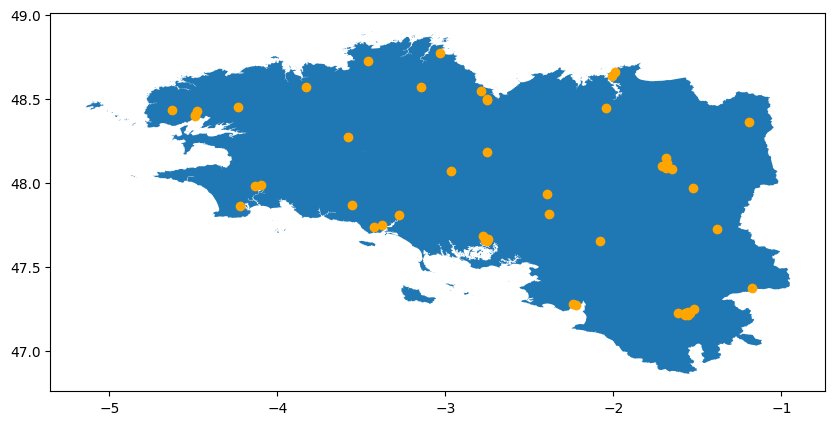

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,20))
geo_bzh.plot(ax=ax)
carto_mat.plot(ax=ax,color="orange")

Et, enfin, nous pouvons sauvegarder les deux bases de données géographiques en prévision d'une réutilisation prochaine.

In [48]:
geo_bzh.to_file("raw/contours_bzh.json",driver="GeoJSON")
carto_mat.to_file("data/mat.json",driver="GeoJSON")

C:\Users\raphi\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Suite du programme : créer un diagramme de Voronoï pour chaque année !